In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.17.0


In [3]:
def load_data(datasets, percentage=1):
    """
    datasets: dict of dataset name and its corresponding input data and ground truth
    """
    # For every dataset path in datasets
        # Get the jpg files 
        # Sort them
        # Print "Loaded {dataset}"
        # Assert len(input_paths) == len(labels_paths)
    # Create tensor slies for the input and ground labels
    # Zip them together

    # Python list of all the paths of every input in every dataset
    input_paths = []
    gt_paths = []

    image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
    
    for dataset in datasets:
        print(f"Loading in {dataset} dataset...")
        # Get the input and ground truth paths
        input_dir, gt_dir = datasets[dataset]

        # Get a python list of all the paths of the pictures
        input_path = []
        gt_path = []
        for ext in image_extensions:
            input_path.extend(tf.io.gfile.glob(os.path.join(input_dir, ext)))
            gt_path.extend(tf.io.gfile.glob(os.path.join(gt_dir, ext)))

        # Sort the files so they can be mapped correctly
        input_path = sorted(input_path)
        gt_path = sorted(gt_path)

        # Ensure that their lengths are equal
        assert len(input_path) == len(gt_path), f"input_path length: {len(input_path)}, gt_path length: {(len(gt_path))}"

        # Print the first input file and its corresponding label for confirmation
        # print(f"Input: {input_path[0]} Label: {gt_path[0]}")

        # Add the paths to input_paths to then zip up the dataset
        input_paths.extend(input_path)
        gt_paths.extend(gt_path)
        
        print("Finished Loading")

    cutoff = int(len(input_paths) * percentage)
    
    # Create tensor slices of the inputs
    ds_input = tf.data.Dataset.from_tensor_slices(input_paths[:cutoff])
    gt_path  = tf.data.Dataset.from_tensor_slices(gt_paths[:cutoff])

    # Zip up the dataset so that each image has its corresponding label
    ds = tf.data.Dataset.zip(ds_input, gt_path)

    return ds
    

In [4]:
seed = 41
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
LSUI_data_dir = "/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI"
LSUI_input_dir = f"{LSUI_data_dir}/input"
LSUI_gt_dir = f"{LSUI_data_dir}/GT"

EUVP_UNDERWATER_IMAGENET_data_dir = "/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet"
EUVP_UNDERWATER_IMAGENET_input_dir = f"{EUVP_UNDERWATER_IMAGENET_data_dir}/trainA"
EUVP_UNDERWATER_IMAGENET_gt_dir = f"{EUVP_UNDERWATER_IMAGENET_data_dir}/trainB"

EUVP_UNDERWATER_SCENES_data_dir = "/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes"
EUVP_UNDERWATER_SCENES_input_dir = f"{EUVP_UNDERWATER_SCENES_data_dir}/trainA"
EUVP_UNDERWATER_SCENES_gt_dir = f"{EUVP_UNDERWATER_SCENES_data_dir}/trainB"

UNDERWATER_IMAGENET_data_dir = "/kaggle/input/underwater-imagenet-dataset/underwater_imagenet"
UNDERWATER_IMAGENET_input_dir = f"{UNDERWATER_IMAGENET_data_dir}/trainB"
UNDERWATER_IMAGENET_gt_dir = f"{UNDERWATER_IMAGENET_data_dir}/trainB"

datasets = {
    "LSUI": (LSUI_input_dir, LSUI_gt_dir),
    "EUVP Underwater Scenes": (EUVP_UNDERWATER_SCENES_input_dir, EUVP_UNDERWATER_SCENES_gt_dir),
    "EUVP Underwater ImageNet": (EUVP_UNDERWATER_IMAGENET_input_dir, EUVP_UNDERWATER_IMAGENET_gt_dir),
    "Underwater ImageNet bigger version": (UNDERWATER_IMAGENET_input_dir, UNDERWATER_IMAGENET_gt_dir)
}

ds = load_data(datasets, 1)

Loading in LSUI dataset...
Finished Loading
Loading in EUVP Underwater Scenes dataset...
Finished Loading
Loading in EUVP Underwater ImageNet dataset...
Finished Loading
Loading in Underwater ImageNet bigger version dataset...
Finished Loading


In [6]:
DATASET_SIZE = tf.data.experimental.cardinality(ds).numpy()
print(f"There are: {DATASET_SIZE} image pairs")

There are: 16292 image pairs


In [7]:
batch_size = 16
img_height = 128
img_width = 128

In [8]:
# Split the dataset into 80% for training and 20% for validation/dev set
val_size = int(DATASET_SIZE * 0.2)
train_ds = ds.skip(val_size)
val_ds = ds.take(val_size)
print(val_size)

3258


In [9]:
print(f"Training size: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_ds).numpy()}")

Training size: 13034
Validation size: 3258


In [10]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_image(img, channels=3, expand_animations=False)

    # Normalize the image values to be in the [0, 1] range
    input_img = tf.cast(img, tf.float32) / 255.0
    
    # Resize the image to the desired size
    return tf.image.resize(input_img, [img_height, img_width])

In [11]:
def process_path(input_path, gt_path):
    # Load the raw data from the file as a string
    input_img = tf.io.read_file(input_path)
    gt_img = tf.io.read_file(gt_path)

    input_img = decode_img(input_img)
    gt_img = decode_img(gt_img)
    return input_img, gt_img

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (128, 128, 3)
Label:  (128, 128, 3)


In [14]:
def configure_for_performance(ds, seed=seed):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000, seed=seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [15]:
train_ds = configure_for_performance(train_ds, seed=seed)
val_ds = configure_for_performance(val_ds, seed=seed)

In [16]:
# Every batch has 16 images of shape 128x128 and 3 color channels (RGB)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 128, 128, 3)
(16, 128, 128, 3)


In [17]:
print(f"Training dataset has: {tf.data.experimental.cardinality(train_ds).numpy()} batches")
print(f"Validation size has: {tf.data.experimental.cardinality(val_ds).numpy()} batches")

Training dataset has: 815 batches
Validation size has: 204 batches


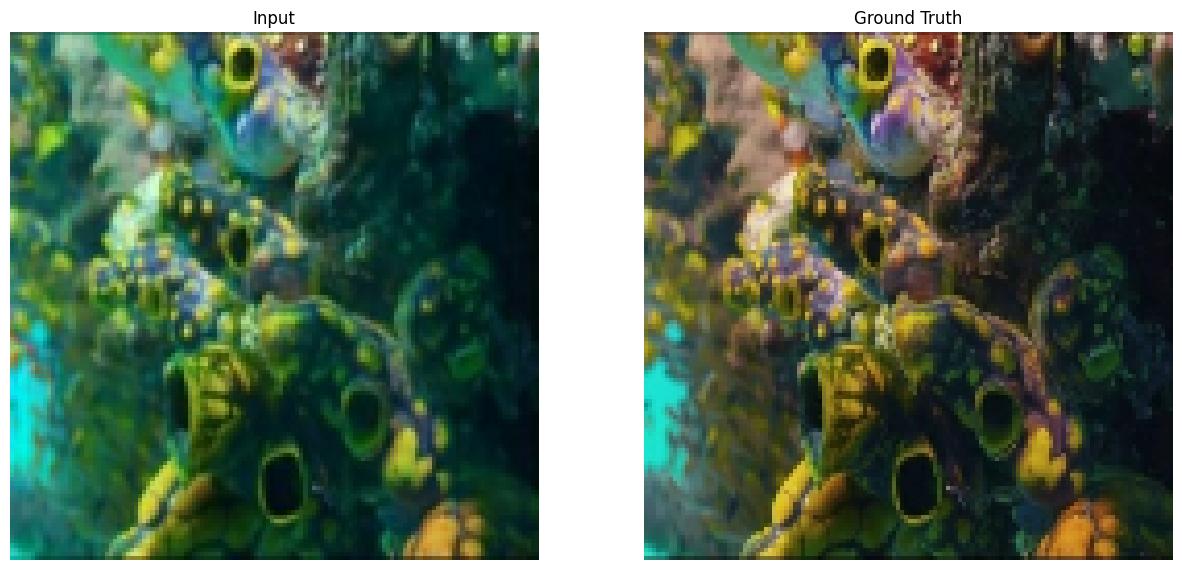

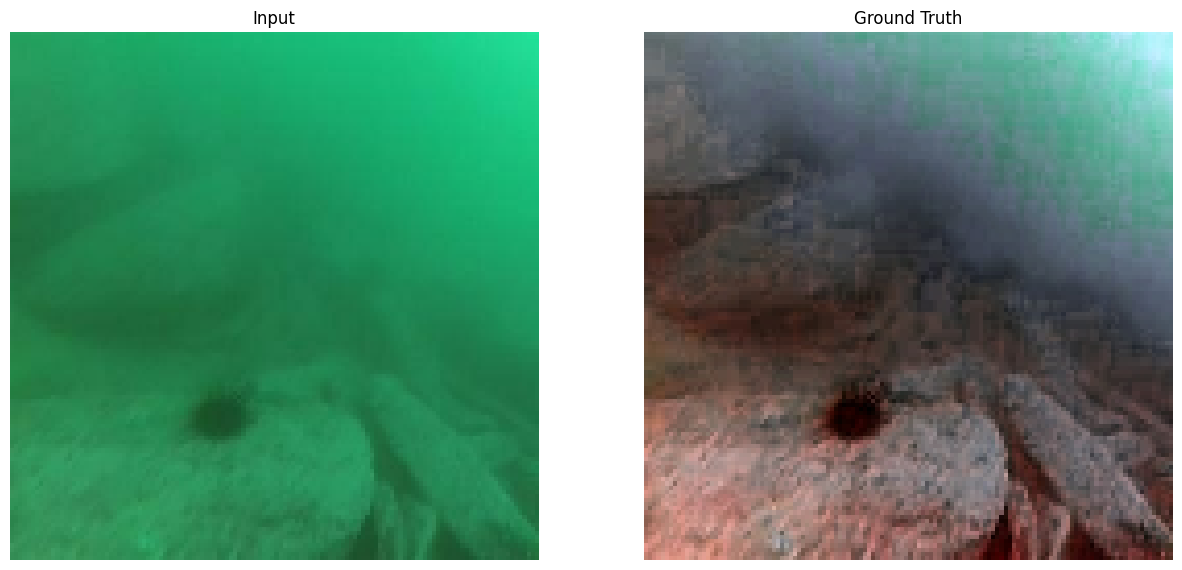

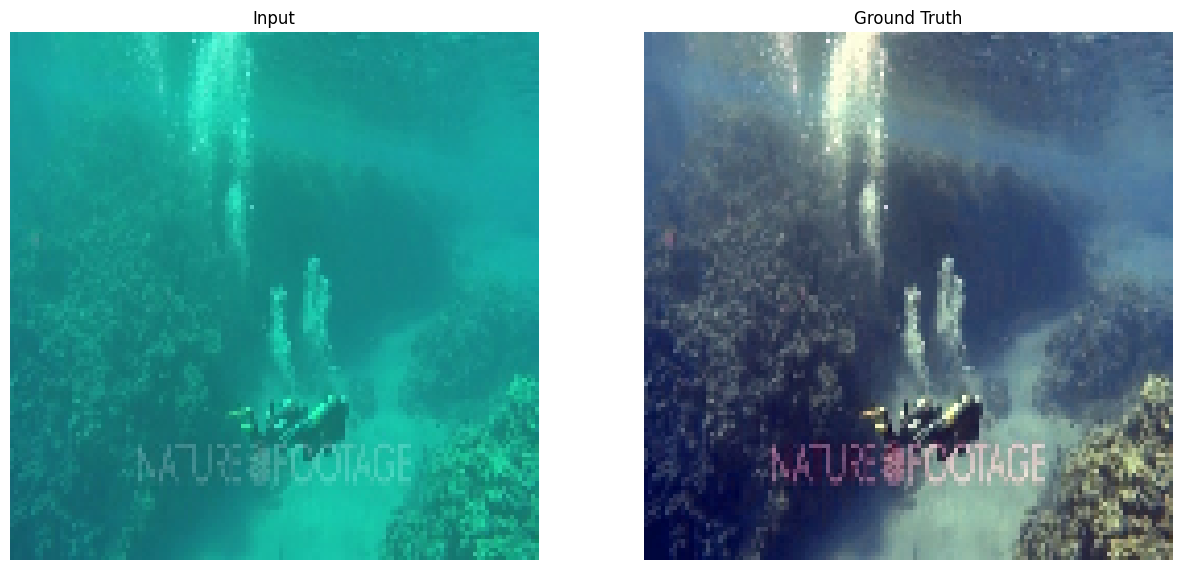

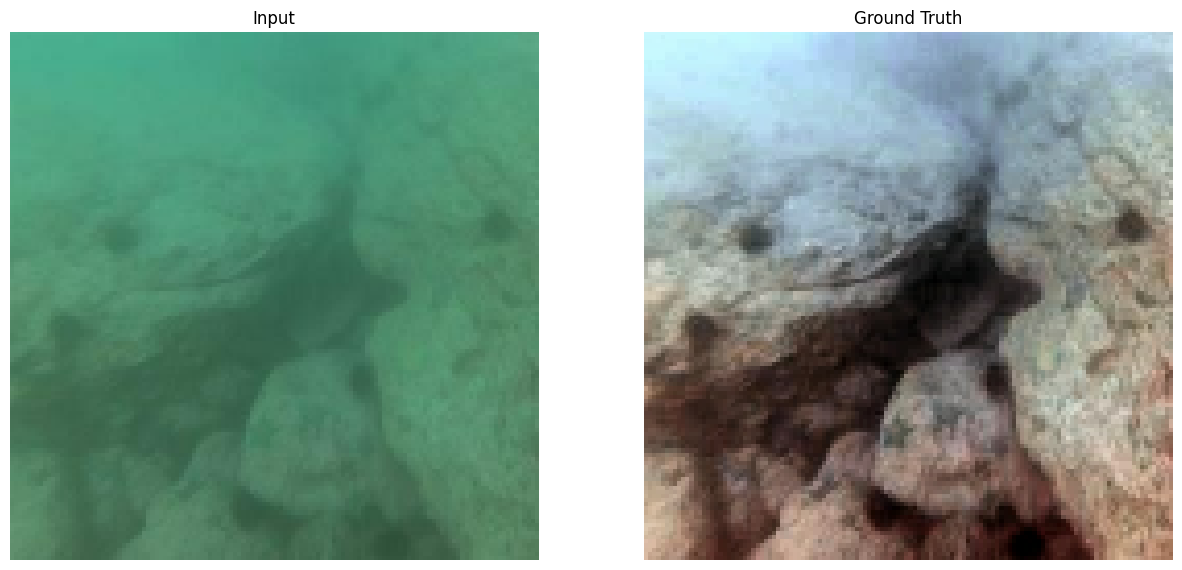

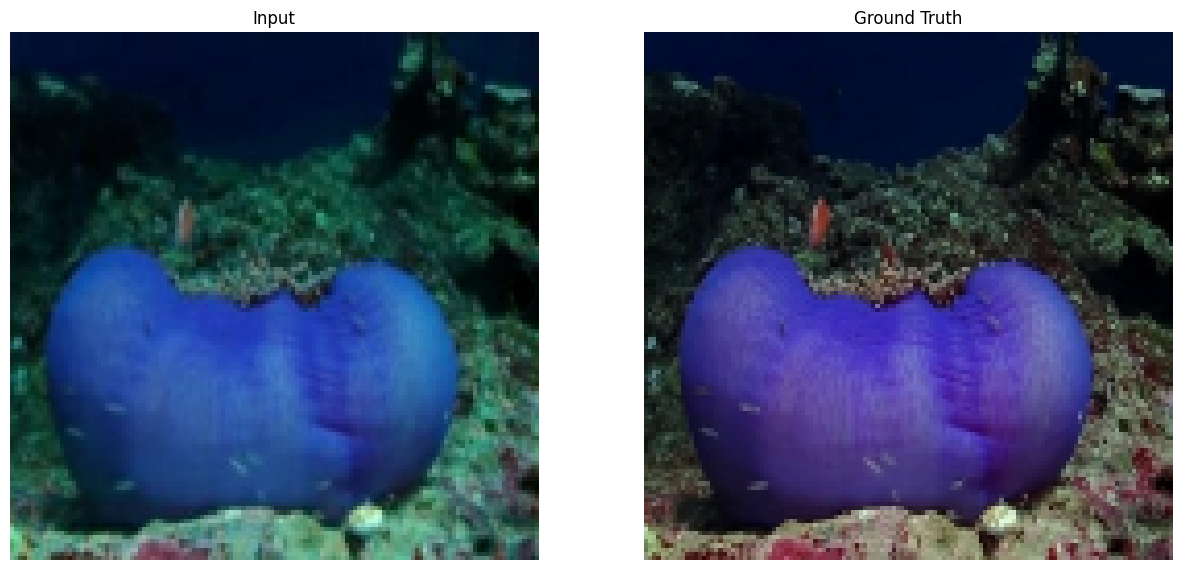

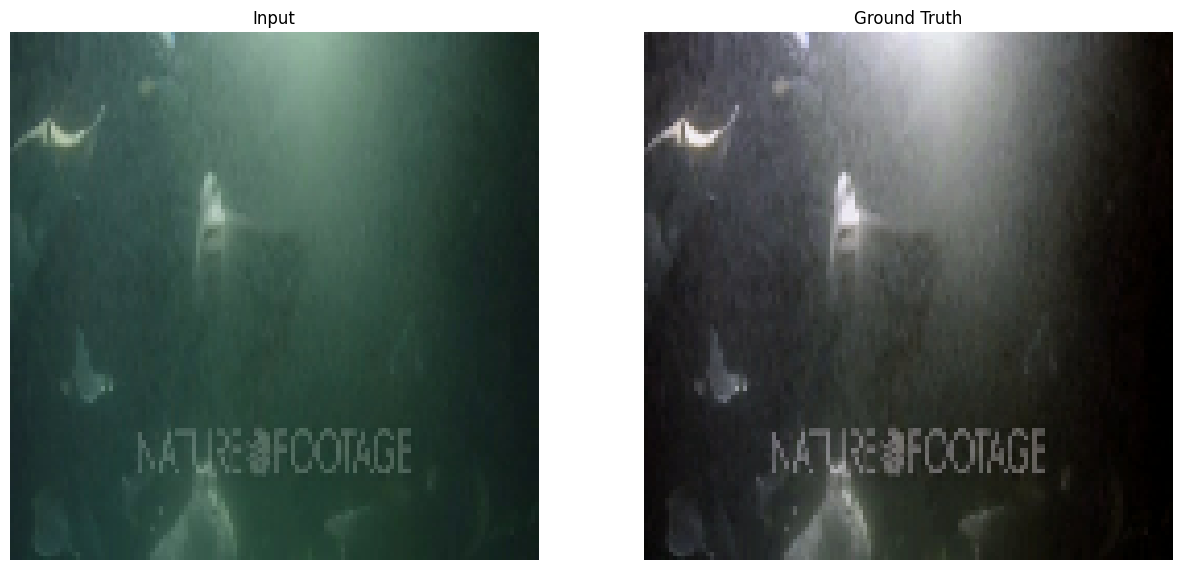

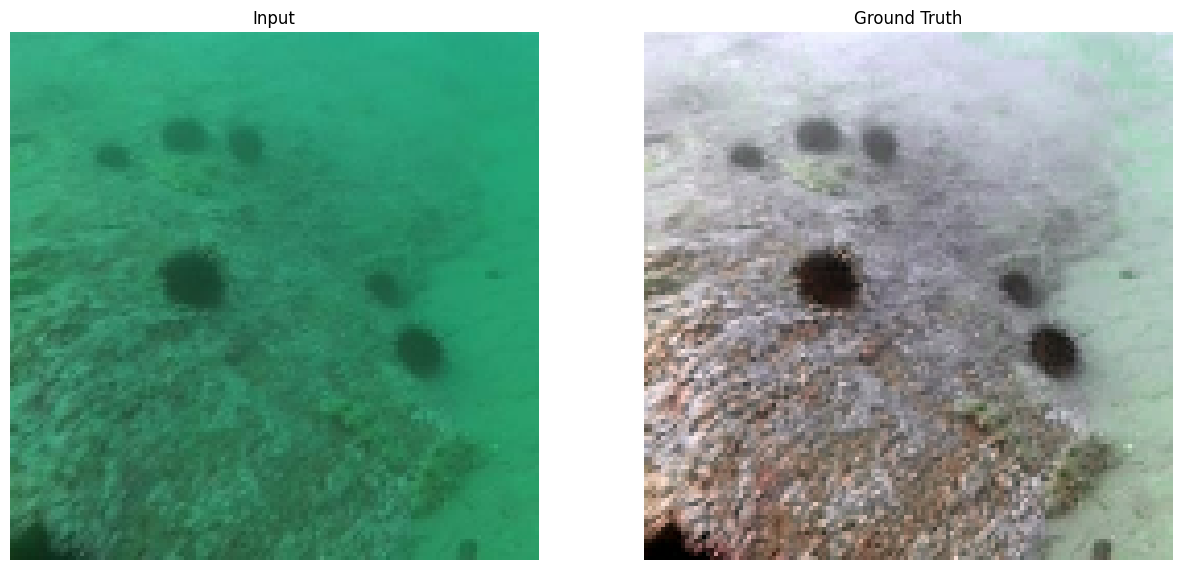

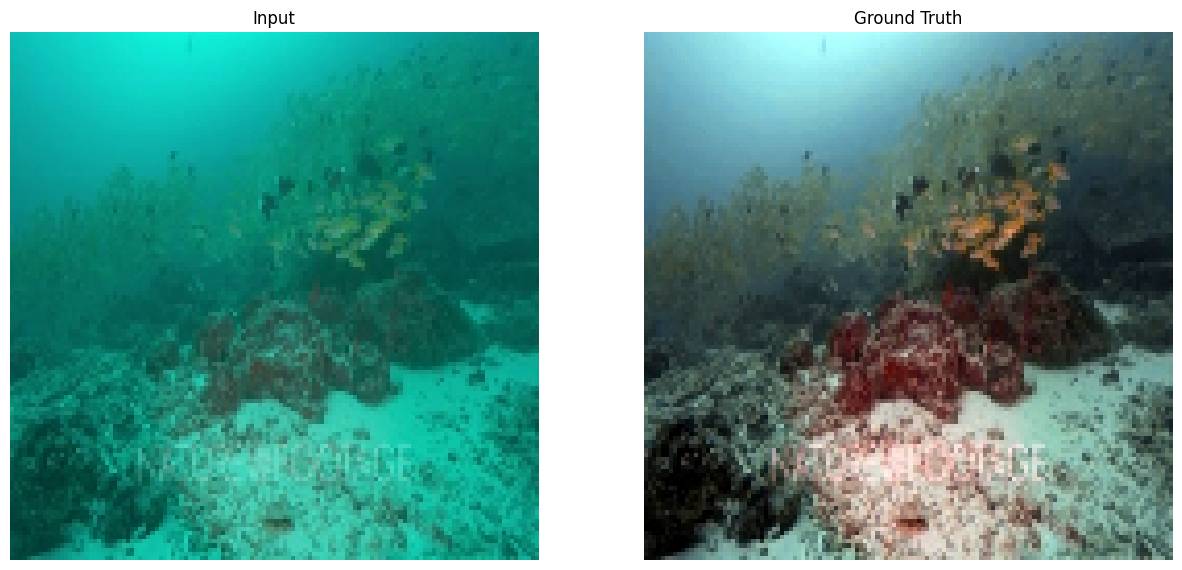

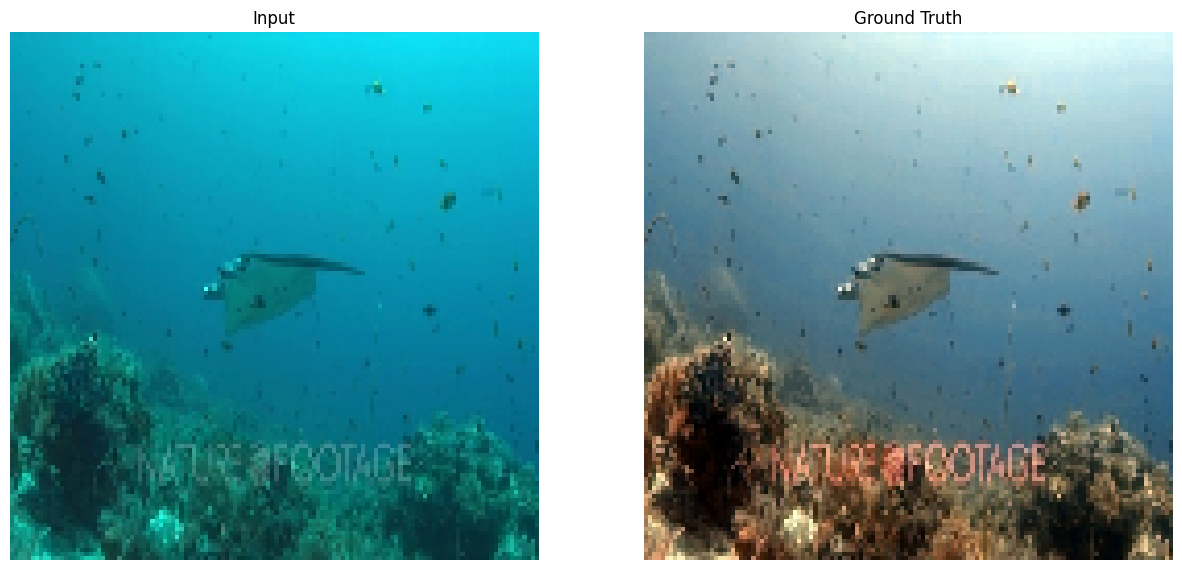

In [18]:
import matplotlib.pyplot as plt

image_batch, gt_batch = next(iter(train_ds))

for i in range(9):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow((image_batch[i].numpy() * 255).astype("uint8"))
    plt.title('Input')
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow((gt_batch[i].numpy() * 255).astype("uint8"))
    plt.title('Ground Truth')
    plt.axis("off")
    plt.show()


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, losses, initializers
from tensorflow.keras.models import Model

In [20]:
@tf.keras.utils.register_keras_serializable()
class TransitionUp(layers.Layer):
    """
    Performs the upsampling step: tranposed conv by a stride of 2 and concatenates it skip connections.

    Steps:
        1. 3x3 Transposed Convolution, stride = 2
        2. Concatenate the activation maps generated with skip connection
    """

    def __init__(self, n_filters_keep, name="TransitionUp"):
        super().__init__(name=name)
        self.deconv = layers.Conv2DTranspose(
            filters=n_filters_keep,
            kernel_size=3,
            strides=2,
            padding='same',
            kernel_initializer=initializers.HeUniform(),
            activation=None
        )

        self.concat = layers.Concatenate(axis=-1)
    
    def call(self, inputs):
        if not isinstance(inputs, (list, tuple)) or len(inputs) != 2:
            raise ValueError("TransitionUp layer expects inputs as a list or tuple of two tensors: [block_to_upsample, skip_connection].")

        blocks_to_upsample, skip_connection = inputs

        upsampled = self.deconv(blocks_to_upsample)

        concatenated  = self.concat([upsampled, skip_connection])
        return concatenated
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "n_filters_keep": self.deconv.filters,
            "name": self.name
        })
        return config
        

In [21]:
@tf.keras.utils.register_keras_serializable()
class BN_ReLU_Conv(layers.Layer):
    """
    Applies batch normalization, ReLU, convolution and drop out
    """

    def __init__(self, n_filters, filter_size=3, dropout_p=0.2, name="BN_ReLU_Conv"):
        super().__init__(name=name)
        
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv = layers.Conv2D(
            filters =n_filters,
            kernel_size=filter_size,
            padding='same',
            kernel_initializer=initializers.HeUniform(),
            activation=None
        )

        self.dropout_p = dropout_p
        if self.dropout_p > 0.0:
            self.dropout = layers.Dropout(rate=self.dropout_p)
        else:
            self.dropout = None

    def call(self, inputs, training=False):
        x = self.bn(inputs, training=training)
        x = self.relu(x)
        x = self.conv(x)

        if self.dropout is not None:
            x = self.dropout(x, training=training)
        return x
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "n_filters": self.conv.filters,
            "filter_size": self.conv.kernel_size[0],
            "dropout_p": self.dropout_p,
            "name": self.name
        })
        return config

In [22]:
@tf.keras.utils.register_keras_serializable()
class TransitionDown(layers.Layer):
    """
    Performs the downsampling step: BN, ReLu, Conv then max pooling
        1. Batch normalization
        2. Relu activation
        3. 1x1 Convolution
        4. 2x2 Max Pooling
    """

    def __init__(self, n_filters, dropout_p=0.2, name="TransitionDown"):
        super().__init__(name=name)

        self.bn_relu_conv = BN_ReLU_Conv(n_filters=n_filters, dropout_p=dropout_p)
        self.maxpool = layers.MaxPooling2D(pool_size=(2,2), padding='same')

    def call(self, inputs, training=False):
        x = self.bn_relu_conv(inputs, training=training)
        x = self.maxpool(x)

        return x
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "n_filters": self.bn_relu_conv.conv.filters,
            "dropout_p": self.bn_relu_conv.dropout_p,
            "name": self.name
        })
        return config

In [23]:
@tf.keras.utils.register_keras_serializable()
class DenseBlock(layers.Layer):
    """
    Creates a Dense Block with the specified number of layers and growth rate
    """
    def __init__(self, num_layers, growth_rate, dropout_p=0.2, name='dense_block'):
        super().__init__(name=name)
        self.num_layers = num_layers
        self.growth_rate = growth_rate
        self.layers_list = []
        
        for i in range(num_layers):
            self.layers_list.append(
                BN_ReLU_Conv(
                    n_filters=growth_rate,
                    filter_size=3,
                    dropout_p=dropout_p,
                    name=f'{name}_layer_{i+1}'
                )
            )
        self.concat = layers.Concatenate(axis=-1)
    
    def call(self, x, training=False):
        for layer in self.layers_list:
            new_features = layer(x, training=training)
            x = self.concat([x, new_features])
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "growth_rate": self.growth_rate,
            "dropout_p": self.layers_list[0].dropout_p,
            "name": self.name
        })
        return config

In [24]:
@tf.keras.utils.register_keras_serializable()
class FCDenseNet(Model):
    def __init__(
        self,
        name="FCDenseNet",
        n_filters_first_conv=48,
        n_pool=2,
        input_dim=(None, None, 3),
        growth_rate=4,
        n_layers_per_block=2,
        dropout_p=0.2,
    ):
        super().__init__(name=name)
        
        if isinstance(n_layers_per_block, list):
            assert (len(n_layers_per_block) == 2 * n_pool + 1)
        elif isinstance(n_layers_per_block, int):
            n_layers_per_block = [n_layers_per_block] * (2 * n_pool + 1)
        else:
            raise ValueError("n_layers_per_block must be either an integer or a list")
            
        self.n_pool = n_pool
        self.growth_rate = growth_rate
        self.n_layers_per_block = n_layers_per_block
        self.dropout_p = dropout_p
        
        # First convolution
        self.first_conv = layers.Conv2D(
            filters=n_filters_first_conv,
            kernel_size=3,
            padding='same',
            kernel_initializer=initializers.HeUniform(),
            activation=None
        )

        # Initialize all blocks
        self.down_dense_blocks = []
        self.down_transition_blocks = []
        for i in range(n_pool):
            self.down_dense_blocks.append(
                DenseBlock(
                    num_layers=n_layers_per_block[i],
                    growth_rate=growth_rate,
                    dropout_p=dropout_p,
                    name=f'down_dense_block_{i}'
                )
            )
            self.down_transition_blocks.append(
                TransitionDown(
                    n_filters=n_filters_first_conv + growth_rate * n_layers_per_block[i],
                    dropout_p=dropout_p,
                    name=f'transition_down_{i}'
                )
            )

        # Bottleneck
        self.bottleneck = DenseBlock(
            num_layers=n_layers_per_block[n_pool],
            growth_rate=growth_rate,
            dropout_p=dropout_p,
            name='bottleneck'
        )

        # Upsampling path
        self.up_dense_blocks = []
        self.up_transition_blocks = []
        for i in range(n_pool):
            n_filters_keep = growth_rate * n_layers_per_block[n_pool + i]
            self.up_transition_blocks.append(
                TransitionUp(
                    n_filters_keep=n_filters_keep,
                    name=f'transition_up_{i}'
                )
            )
            self.up_dense_blocks.append(
                DenseBlock(
                    num_layers=n_layers_per_block[n_pool + 1 + i],
                    growth_rate=growth_rate,
                    dropout_p=dropout_p,
                    name=f'up_dense_block_{i}'
                )
            )

        # Final convolution
        self.final_conv = layers.Conv2D(
            filters=3,
            kernel_size=1,
            padding="same",
            kernel_initializer=initializers.HeUniform(),
            activation="sigmoid",
            name="output"
        )

    def call(self, inputs, training=False):
        stack = self.first_conv(inputs)
        skip_connections = []
        
        # Downsampling path
        for i in range(self.n_pool):
            stack = self.down_dense_blocks[i](stack, training=training)
            skip_connections.append(stack)
            stack = self.down_transition_blocks[i](stack, training=training)
        
        # Bottleneck
        stack = self.bottleneck(stack, training=training)
        
        # Upsampling path
        skip_connections = skip_connections[::-1]
        for i in range(self.n_pool):
            stack = self.up_transition_blocks[i]([stack, skip_connections[i]])
            stack = self.up_dense_blocks[i](stack, training=training)
        
        return self.final_conv(stack)
        
    def get_config(self):
        config = super(FCDenseNet, self).get_config()
        config.update({
            "name": self.name,
            "n_filters_first_conv": self.first_conv.filters,
            "n_pool": self.n_pool,
            "input_dim": self.first_conv.input_shape if hasattr(self.first_conv, 'input_shape') else None,
            "growth_rate": self.growth_rate,
            "n_layers_per_block": self.n_layers_per_block,
            "dropout_p": self.dropout_p
        })
        return config


In [25]:
fcdensenet = FCDenseNet(input_dim=(128, 128, 3))

In [26]:
fcdensenet.compile(optimizer="adam", loss=losses.MeanSquaredError())

In [27]:
fcdensenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

Epoch 1/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 103s 88ms/step - loss: 0.0155 - val_loss: 0.0174
Epoch 2/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0091 - val_loss: 0.0158
Epoch 3/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0083 - val_loss: 0.0155
Epoch 4/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0080 - val_loss: 0.0150
Epoch 5/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0080 - val_loss: 0.0144
Epoch 6/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0079 - val_loss: 0.0141
Epoch 7/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0074 - val_loss: 0.0144
Epoch 8/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0076 - val_loss: 0.0132
Epoch 9/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0075 - val_loss: 0.0134
Epoch 10/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0073 - val_loss: 0.0142
Epoch 11/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0074 - val_loss: 0.0138
Epoch 12/50
815/815 ━━━━━━━━━

In [28]:
fcdensenet.summary()

Model: "FCDenseNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 48)        │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ down_dense_block_0 (DenseBlock)      │ ?                           │           4,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_down_0 (TransitionDown)   │ ?                           │          28,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ down_dense_block_1 (DenseBlock)      │ ?                           │           4,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_down_1 (TransitionDown)   │ ?                           │          32,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (DenseBlock)              │ ?                           │           4,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_up_0 (TransitionUp)       │ ?                           │           4,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_dense_block_0 (DenseBlock)        │ ?                           │           5,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_up_1 (TransitionUp)       │ ?                           │           5,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_dense_block_1 (DenseBlock)        │ ?                           │           5,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Conv2D)                      │ (None, 128, 128, 3)         │             219 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 289,691 (1.11 MB)

 Trainable params: 96,075 (375.29 KB)

 Non-trainable params: 1,464 (5.72 KB)

 Optimizer params: 192,152 (750.60 KB)

In [29]:
import matplotlib.pyplot as plt

image_batch, gt_batch = next(iter(train_ds))

reconstructed_batch = fcdensenet.predict(image_batch)
print(reconstructed_batch[0])
print(reconstructed_batch.shape)

reconstructed_batch = np.clip(reconstructed_batch * 255.0, 0, 255).astype('uint8')
print(reconstructed_batch.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
[[[0.18947886 0.22735469 0.16148919]
  [0.17714399 0.24247357 0.15031707]
  [0.16298093 0.22933945 0.14290656]
  ...
  [0.10095433 0.14544286 0.1085462 ]
  [0.08833219 0.12665138 0.09160117]
  [0.1007421  0.12597026 0.09183371]]

 [[0.19254628 0.25710887 0.16603644]
  [0.16492379 0.2571563  0.15458669]
  [0.14902875 0.23877051 0.1401461 ]
  ...
  [0.08920018 0.15166727 0.11165036]
  [0.0777493  0.13023144 0.08690362]
  [0.08096248 0.1151663  0.07970496]]

 [[0.1832227  0.248779   0.16737278]
  [0.15616277 0.25020632 0.15361391]
  [0.14627609 0.23862359 0.14380921]
  ...
  [0.0911143  0.16059716 0.11672355]
  [0.07710201 0.14240032 0.09427506]
  [0.07639325 0.11671785 0.07963402]]

 ...

 [[0.20661555 0.24357681 0.15822658]
  [0.15192293 0.21820362 0.12844916]
  [0.14292917 0.21127589 0.124956  ]
  ...
  [0.32048002 0.49640223 0.3858334 ]
  [0.42929843 0.6498124  0.4933752 ]
  [0.41052586 0.61745906 0.41939065]]

 [[0.20423988 0.23598309 0.15269773

In [30]:
# print(len(reconstructed_batch))
reconstructed_batch[0]

array([[[ 48,  57,  41],
        [ 45,  61,  38],
        [ 41,  58,  36],
        ...,
        [ 25,  37,  27],
        [ 22,  32,  23],
        [ 25,  32,  23]],

       [[ 49,  65,  42],
        [ 42,  65,  39],
        [ 38,  60,  35],
        ...,
        [ 22,  38,  28],
        [ 19,  33,  22],
        [ 20,  29,  20]],

       [[ 46,  63,  42],
        [ 39,  63,  39],
        [ 37,  60,  36],
        ...,
        [ 23,  40,  29],
        [ 19,  36,  24],
        [ 19,  29,  20]],

       ...,

       [[ 52,  62,  40],
        [ 38,  55,  32],
        [ 36,  53,  31],
        ...,
        [ 81, 126,  98],
        [109, 165, 125],
        [104, 157, 106]],

       [[ 52,  60,  38],
        [ 47,  65,  38],
        [ 45,  65,  40],
        ...,
        [ 89, 141, 111],
        [115, 181, 143],
        [109, 171, 118]],

       [[ 55,  60,  43],
        [ 44,  56,  36],
        [ 46,  58,  37],
        ...,
        [ 62,  97,  76],
        [ 79, 137, 102],
        [ 97, 151, 106]]

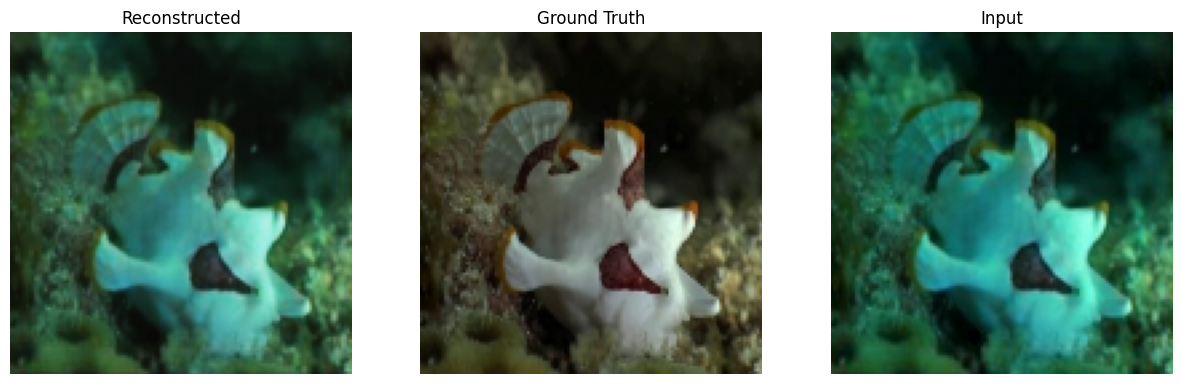

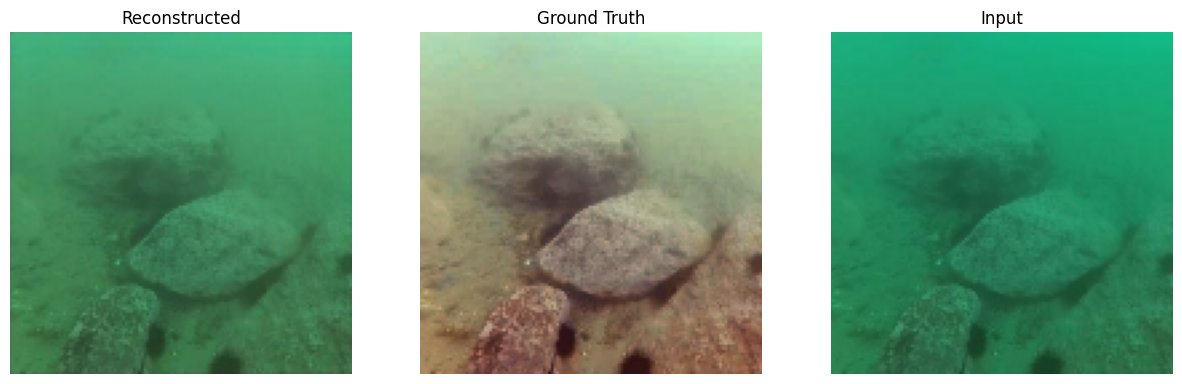

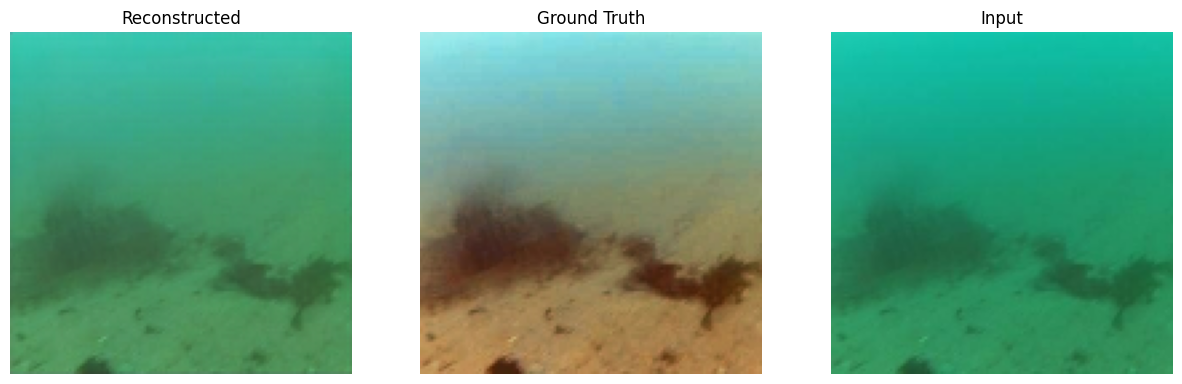

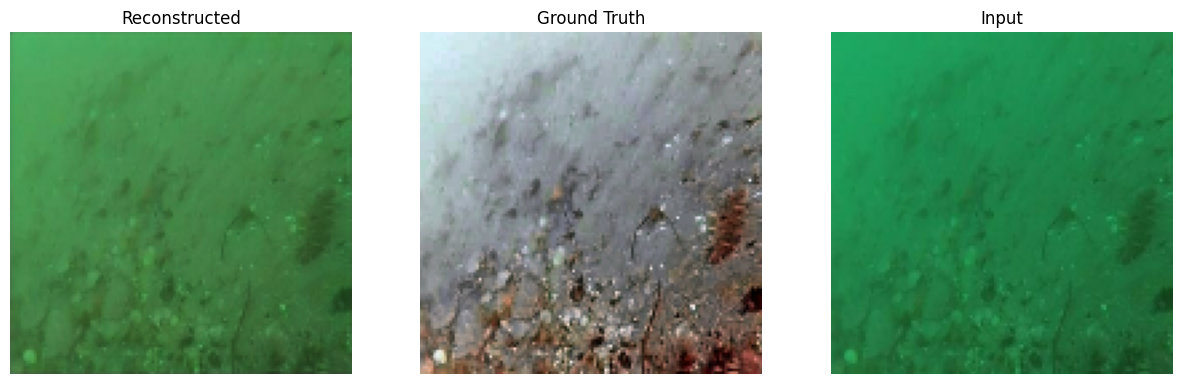

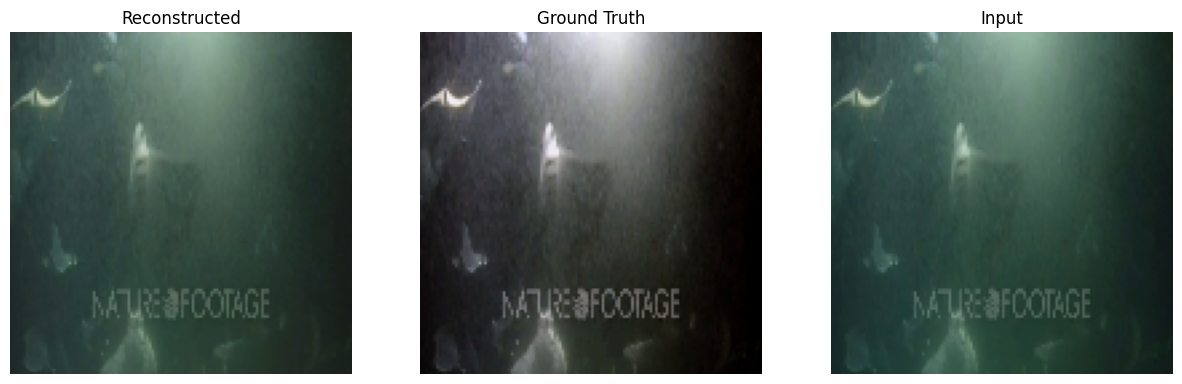

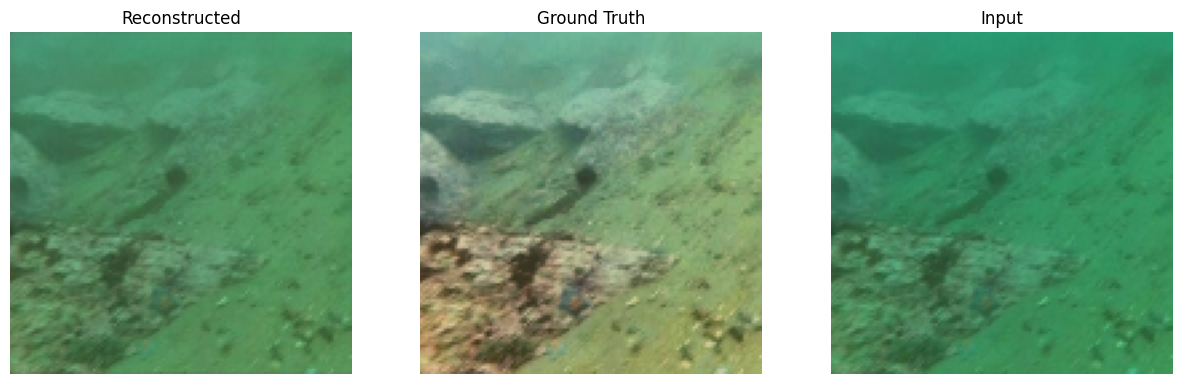

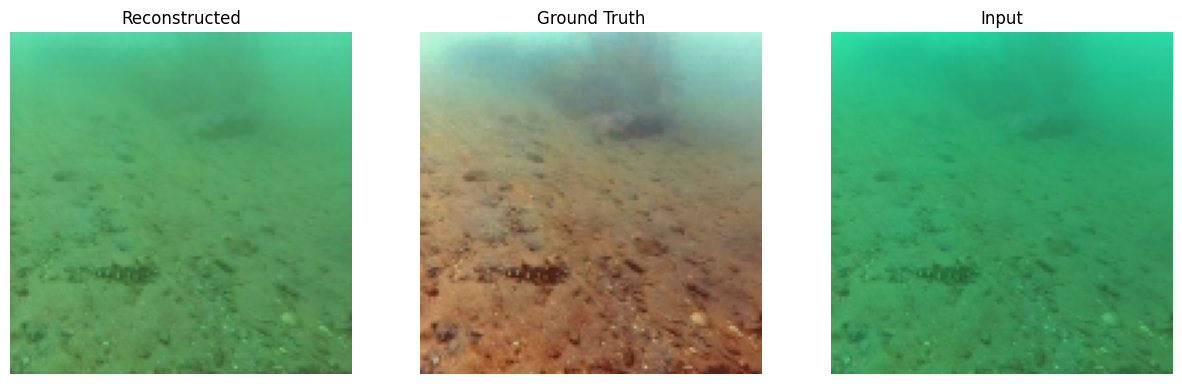

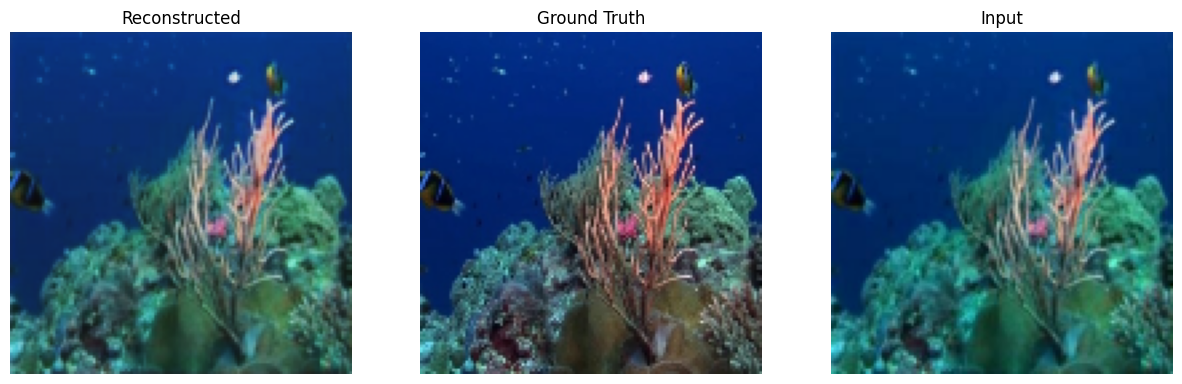

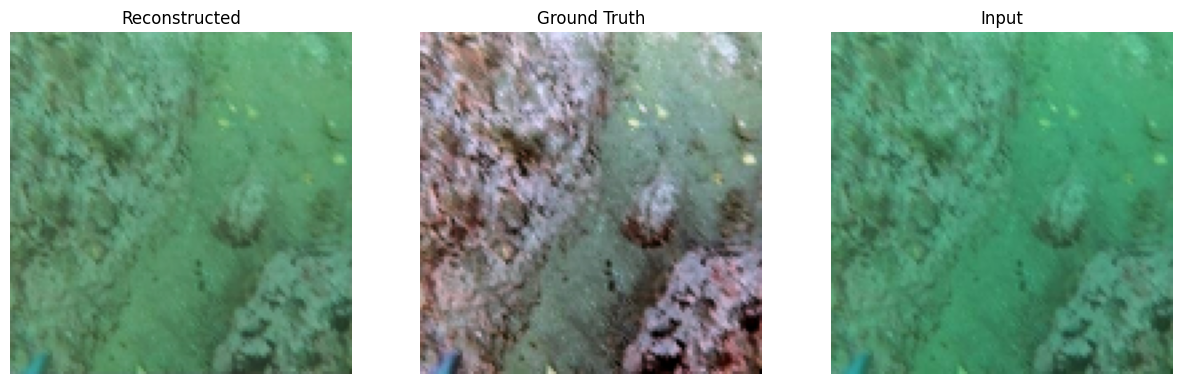

In [31]:
for i in range(9):
    plt.figure(figsize=(15, 10))
    
    # Reconstructed Image
    plt.subplot(1, 3, 1)
    plt.imshow(reconstructed_batch[i])
    plt.title('Reconstructed')
    plt.axis("off")
    
    # Ground Truth Image
    gt_image = gt_batch[i].numpy()
    gt_image = np.clip(gt_image * 255.0, 0, 255).astype("uint8")
    plt.subplot(1, 3, 2)
    plt.imshow(gt_image)
    plt.title('Ground Truth')
    plt.axis("off")
    
    # Input Image (for reference)
    input_image = image_batch[i].numpy()
    input_image = np.clip(input_image * 255.0, 0, 255).astype("uint8")
    plt.subplot(1, 3, 3)
    plt.imshow(input_image)
    plt.title('Input')
    plt.axis("off")
    
    plt.show()


In [32]:
fcdensenet.save_weights('fcdensenet.weights.h5')

In [33]:
fcdensenet.save("fcdensenet.h5")